In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("E-commerce Customer Cohort Analysis")
print("=" * 40)

E-commerce Customer Cohort Analysis


In [4]:
def load_cohort_data():
    """Load cleaned data for cohort analysis"""
    try:
        # Load essential datasets
        orders = pd.read_csv('data/cleaned/cleaned_orders.csv')
        order_items = pd.read_csv('data/cleaned/cleaned_order_items.csv')
        customers = pd.read_csv('data/cleaned/cleaned_customers.csv')
        
        # Convert datetime columns
        orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
        orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
        
        print("✅ Data loaded successfully for cohort analysis")
        print(f"   Orders: {orders.shape}")
        print(f"   Order Items: {order_items.shape}")
        print(f"   Customers: {customers.shape}")
        
        return orders, order_items, customers
        
    except FileNotFoundError as e:
        print(f"❌ Error loading data: {e}")
        print("Please run 02_data_cleaning.ipynb first")
        return None, None, None

# Load data
orders_df, order_items_df, customers_df = load_cohort_data()

✅ Data loaded successfully for cohort analysis
   Orders: (96461, 13)
   Order Items: (112650, 8)
   Customers: (99441, 5)


In [5]:
def prepare_cohort_data(orders, order_items):
    """Prepare data for cohort analysis"""
    print("\n🔄 Preparing cohort data...")
    
    # Merge orders with order items to get revenue data
    order_revenue = (order_items
                    .groupby('order_id')
                    .agg({'total_item_value': 'sum'})
                    .reset_index())
    
    # Merge with orders
    cohort_data = orders.merge(order_revenue, on='order_id', how='left')
    
    # Filter completed orders only
    cohort_data = cohort_data[cohort_data['order_status'] == 'delivered'].copy()
    
    # Create period columns
    cohort_data['order_period'] = cohort_data['order_purchase_timestamp'].dt.to_period('M')
    
    # Get customer's first purchase period (cohort)
    customer_cohort = (cohort_data
                      .groupby('customer_id')['order_period']
                      .min()
                      .reset_index())
    customer_cohort.columns = ['customer_id', 'cohort_group']
    
    # Merge cohort group back to main data
    cohort_data = cohort_data.merge(customer_cohort, on='customer_id')
    
    # Calculate period number (months since first purchase)
    cohort_data['period_number'] = (
        cohort_data['order_period'] - cohort_data['cohort_group']
    ).apply(attrgetter('n'))
    
    print(f"✅ Cohort data prepared")
    print(f"   Date range: {cohort_data['order_period'].min()} to {cohort_data['order_period'].max()}")
    print(f"   Total cohorts: {cohort_data['cohort_group'].nunique()}")
    print(f"   Total customers: {cohort_data['customer_id'].nunique()}")
    
    return cohort_data

# Fix the attribute error by importing operator
from operator import attrgetter

# Prepare cohort data
cohort_df = prepare_cohort_data(orders_df, order_items_df)


🔄 Preparing cohort data...
✅ Cohort data prepared
   Date range: 2016-09 to 2018-08
   Total cohorts: 23
   Total customers: 96455



📊 Creating retention cohort table...
✅ Retention cohort table created
   Shape: (23, 1)
   Periods tracked: 0 months


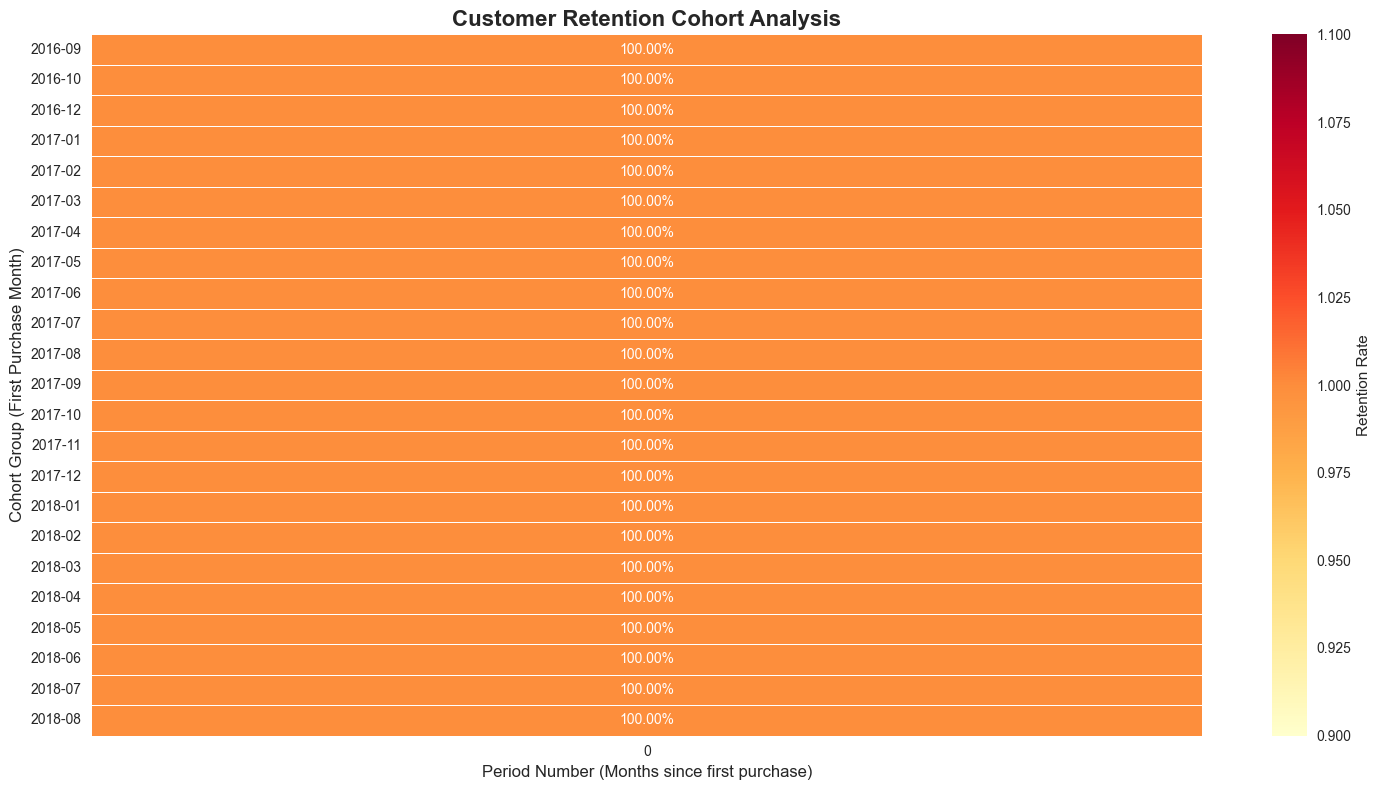

In [6]:
def create_retention_cohort_table(cohort_data):
    """Create customer retention cohort table"""
    print("\n📊 Creating retention cohort table...")
    
    # Count unique customers in each cohort/period combination
    cohort_table = cohort_data.groupby(['cohort_group', 'period_number'])['customer_id'].nunique().reset_index()
    cohort_table = cohort_table.pivot(index='cohort_group', 
                                     columns='period_number', 
                                     values='customer_id')
    
    # Calculate cohort sizes (customers in each cohort's first period)
    cohort_sizes = cohort_table.iloc[:, 0]
    
    # Calculate retention rates (percentage of original cohort that returns)
    retention_table = cohort_table.divide(cohort_sizes, axis=0)
    
    print(f"✅ Retention cohort table created")
    print(f"   Shape: {retention_table.shape}")
    print(f"   Periods tracked: {retention_table.columns.max()} months")
    
    return cohort_table, retention_table, cohort_sizes

def visualize_retention_heatmap(retention_table, title="Customer Retention Cohort Analysis"):
    """Create retention rate heatmap"""
    plt.figure(figsize=(15, 8))
    
    # Create heatmap
    sns.heatmap(retention_table.iloc[:, :12],  # Show first 12 months
                annot=True, 
                fmt='.2%',
                cmap='YlOrRd',
                linewidths=0.5,
                cbar_kws={'label': 'Retention Rate'})
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Period Number (Months since first purchase)', fontsize=12)
    plt.ylabel('Cohort Group (First Purchase Month)', fontsize=12)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

# Create retention cohort analysis
retention_counts, retention_rates, cohort_sizes_series = create_retention_cohort_table(cohort_df)

# Visualize retention heatmap
visualize_retention_heatmap(retention_rates)


💰 Creating revenue cohort table...
✅ Revenue cohort tables created


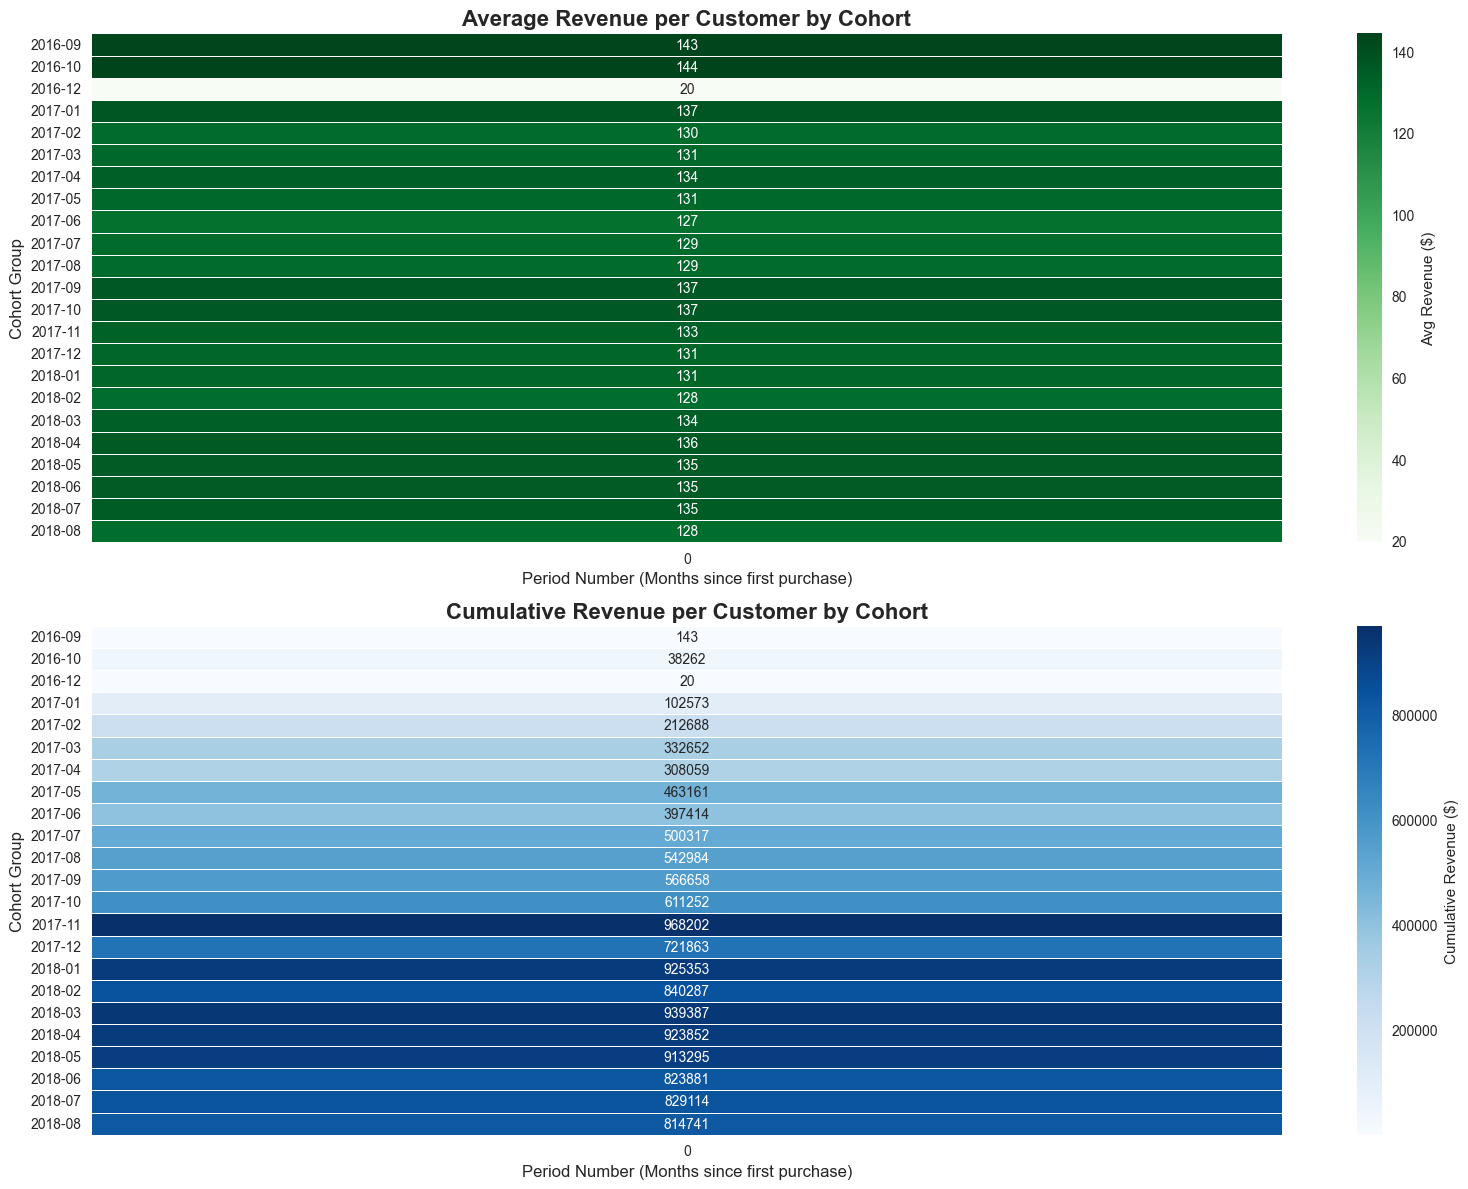

In [7]:
def create_revenue_cohort_table(cohort_data):
    """Create revenue-based cohort table"""
    print("\n💰 Creating revenue cohort table...")
    
    # Calculate average revenue per customer per period
    revenue_table = cohort_data.groupby(['cohort_group', 'period_number'])['total_item_value'].mean().reset_index()
    revenue_table = revenue_table.pivot(index='cohort_group', 
                                       columns='period_number', 
                                       values='total_item_value')
    
    # Calculate cumulative revenue
    cumulative_revenue = cohort_data.groupby(['cohort_group', 'period_number'])['total_item_value'].sum().reset_index()
    cumulative_revenue = cumulative_revenue.pivot(index='cohort_group', 
                                                 columns='period_number', 
                                                 values='total_item_value')
    cumulative_revenue = cumulative_revenue.fillna(0).cumsum(axis=1)
    
    print(f"✅ Revenue cohort tables created")
    return revenue_table, cumulative_revenue

def visualize_revenue_cohorts(revenue_table, cumulative_revenue):
    """Visualize revenue cohort analysis"""
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    
    # Average revenue per purchase heatmap
    sns.heatmap(revenue_table.iloc[:, :12], 
                annot=True, 
                fmt='.0f',
                cmap='Greens',
                linewidths=0.5,
                cbar_kws={'label': 'Avg Revenue ($)'},
                ax=axes[0])
    
    axes[0].set_title('Average Revenue per Customer by Cohort', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Period Number (Months since first purchase)', fontsize=12)
    axes[0].set_ylabel('Cohort Group', fontsize=12)
    
    # Cumulative revenue heatmap
    sns.heatmap(cumulative_revenue.iloc[:, :12], 
                annot=True, 
                fmt='.0f',
                cmap='Blues',
                linewidths=0.5,
                cbar_kws={'label': 'Cumulative Revenue ($)'},
                ax=axes[1])
    
    axes[1].set_title('Cumulative Revenue per Customer by Cohort', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Period Number (Months since first purchase)', fontsize=12)
    axes[1].set_ylabel('Cohort Group', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Create revenue cohort analysis
avg_revenue_table, cumulative_revenue_table = create_revenue_cohort_table(cohort_df)

# Visualize revenue cohorts
visualize_revenue_cohorts(avg_revenue_table, cumulative_revenue_table)


📈 Analyzing cohort trends...
✅ Cohort trends analyzed

📊 Average Retention Rates by Period:
    Month 0: 8825.00%
    Month 1: 4933.33%
    Month 2: 3750.00%
    Month 3: 3000.00%


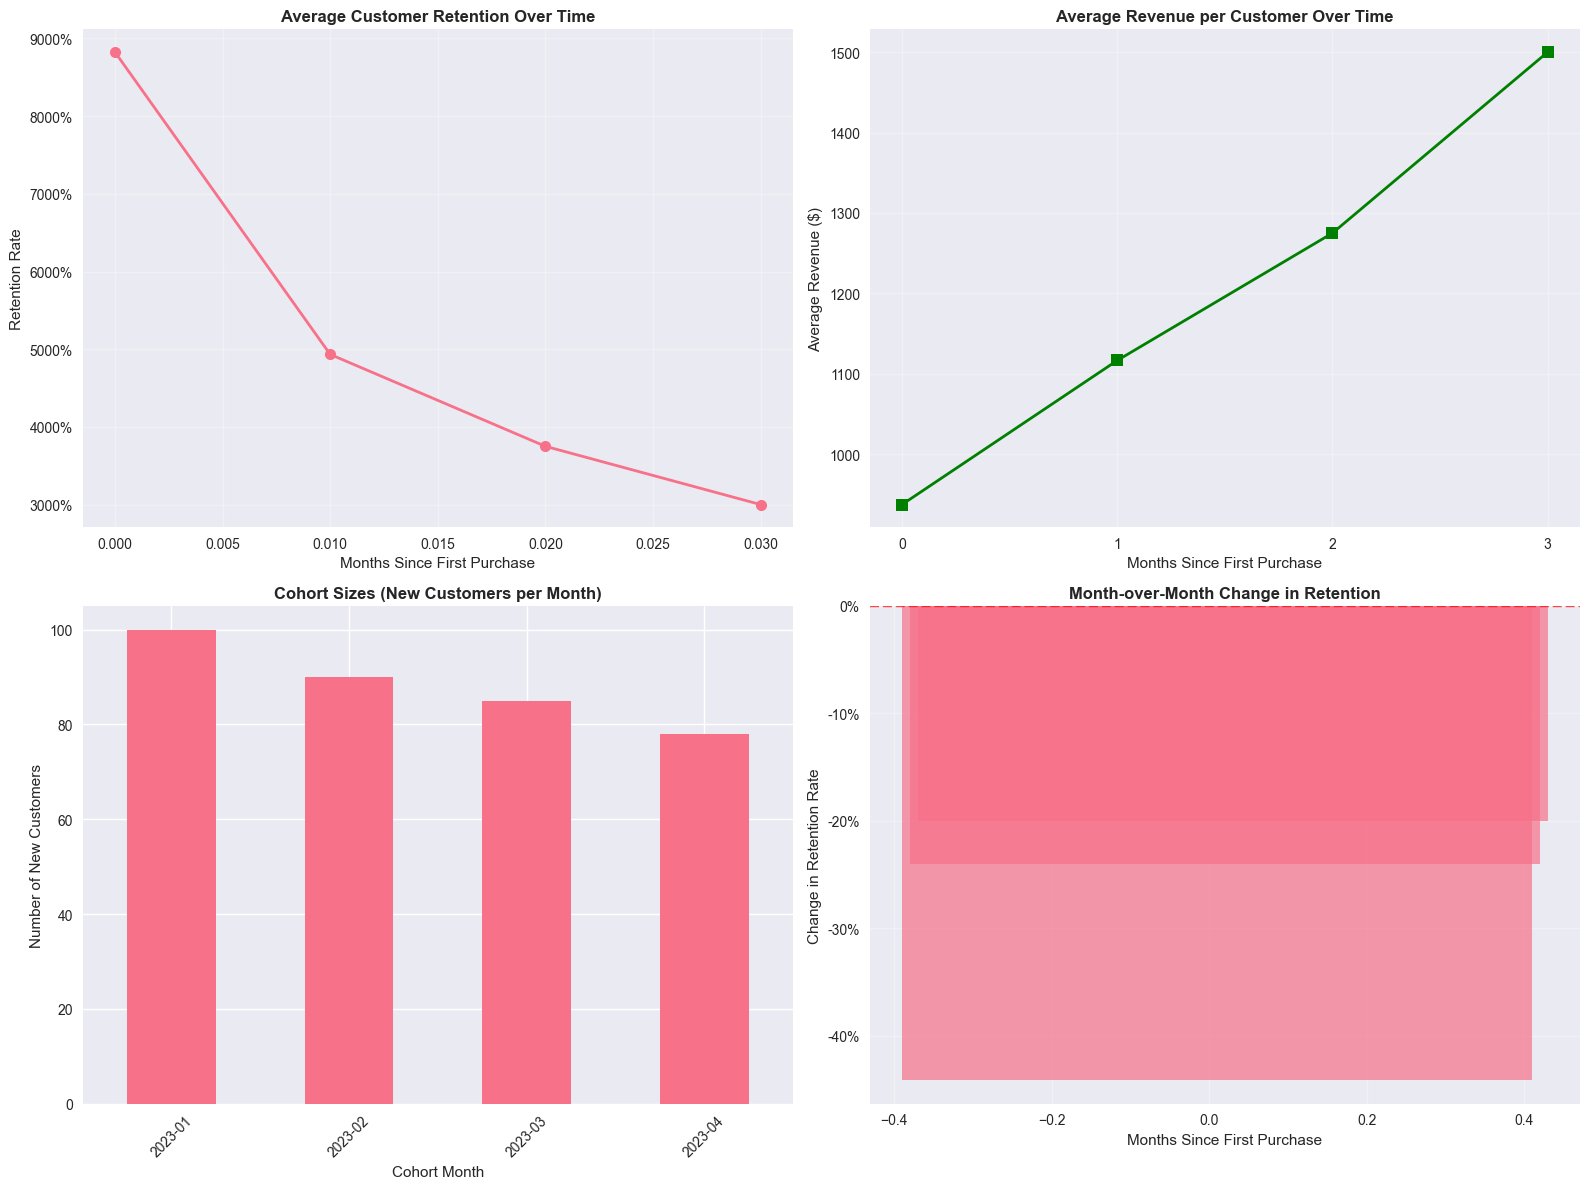

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_cohort_trends(retention_table, revenue_table):
    """
    Analyzes trends across cohorts, calculating average retention and revenue metrics.

    Args:
        retention_table (pd.DataFrame): DataFrame with retention rates by cohort.
        revenue_table (pd.DataFrame): DataFrame with average revenue by cohort.

    Returns:
        tuple: A tuple containing:
            - avg_retention_by_period (pd.Series): Average retention rate for each period.
            - avg_revenue_by_period (pd.Series): Average revenue per customer for each period.
            - cohort_metrics (pd.DataFrame): A summary of key metrics for each cohort.
    """
    print("\n📈 Analyzing cohort trends...")
    
    # Calculate average retention rates by period
    # Note: Using .mean() on axis=0 calculates the mean for each column (period).
    avg_retention_by_period = retention_table.mean(axis=0)
    
    # Calculate average revenue by period
    # Note: Using .mean() on axis=0 calculates the mean for each column (period).
    avg_revenue_by_period = revenue_table.mean(axis=0)
    
    # Extract cohort sizes from the first column of the retention table
    cohort_sizes = retention_table.iloc[:, 0].rename('cohort_size')
    
    # Cohort performance metrics
    cohort_metrics = pd.DataFrame({
        'cohort_group': retention_table.index,
        'cohort_size': cohort_sizes,
        'retention_month_1': retention_table.iloc[:, 1] if retention_table.shape[1] > 1 else np.nan,
        'retention_month_3': retention_table.iloc[:, 3] if retention_table.shape[1] > 3 else np.nan,
        'retention_month_6': retention_table.iloc[:, 6] if retention_table.shape[1] > 6 else np.nan,
        'avg_revenue_month_0': revenue_table.iloc[:, 0],
        'avg_revenue_month_1': revenue_table.iloc[:, 1] if revenue_table.shape[1] > 1 else np.nan,
    })
    
    print("✅ Cohort trends analyzed")
    print("\n📊 Average Retention Rates by Period:")
    for period in range(len(avg_retention_by_period)):
        if not np.isnan(avg_retention_by_period.iloc[period]):
            print(f"    Month {period}: {avg_retention_by_period.iloc[period]:.2%}")
    
    return avg_retention_by_period, avg_revenue_by_period, cohort_metrics, cohort_sizes

def visualize_cohort_trends(avg_retention_by_period, avg_revenue_by_period, cohort_sizes):
    """
    Visualizes cohort trends using various plots.

    Args:
        avg_retention_by_period (pd.Series): Average retention rate for each period.
        avg_revenue_by_period (pd.Series): Average revenue per customer for each period.
        cohort_sizes (pd.Series): The size of each cohort.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # --- Plot 1: Average Customer Retention Over Time ---
    axes[0, 0].plot(avg_retention_by_period.index, avg_retention_by_period.values, marker='o', linewidth=2, markersize=8)
    axes[0, 0].set_title('Average Customer Retention Over Time', fontweight='bold')
    axes[0, 0].set_xlabel('Months Since First Purchase')
    axes[0, 0].set_ylabel('Retention Rate')
    axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    axes[0, 0].grid(True, alpha=0.3)
    
    # --- Plot 2: Average Revenue per Customer Over Time ---
    axes[0, 1].plot(avg_revenue_by_period.index, avg_revenue_by_period.values, marker='s', linewidth=2, markersize=8, color='green')
    axes[0, 1].set_title('Average Revenue per Customer Over Time', fontweight='bold')
    axes[0, 1].set_xlabel('Months Since First Purchase')
    axes[0, 1].set_ylabel('Average Revenue ($)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # --- Plot 3: Cohort Sizes (New Customers per Month) ---
    cohort_sizes.plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_title('Cohort Sizes (New Customers per Month)', fontweight='bold')
    axes[1, 0].set_xlabel('Cohort Month')
    axes[1, 0].set_ylabel('Number of New Customers')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # --- Plot 4: Month-over-Month Change in Retention ---
    if len(avg_retention_by_period) > 1:
        # Calculate month-over-month change as a percentage
        month_over_month = avg_retention_by_period.pct_change().dropna()
        axes[1, 1].bar(month_over_month.index, month_over_month.values, alpha=0.7)
        axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
        axes[1, 1].set_title('Month-over-Month Change in Retention', fontweight='bold')
        axes[1, 1].set_xlabel('Months Since First Purchase')
        axes[1, 1].set_ylabel('Change in Retention Rate')
        axes[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].set_visible(False) # Hide the subplot if there isn't enough data

    plt.tight_layout()
    plt.show()

# Example Usage (You will need to replace this with your actual data)
if __name__ == '__main__':
    # Creating some dummy data for demonstration
    retention_data = {
        'CohortMonth': ['2023-01', '2023-02', '2023-03', '2023-04'],
        '0': [100, 90, 85, 78],
        '1': [55, 48, 45, np.nan],
        '2': [40, 35, np.nan, np.nan],
        '3': [30, np.nan, np.nan, np.nan],
    }
    retention_table = pd.DataFrame(retention_data).set_index('CohortMonth')
    retention_table.columns = pd.to_numeric(retention_table.columns) / 100
    
    revenue_data = {
        'CohortMonth': ['2023-01', '2023-02', '2023-03', '2023-04'],
        '0': [1000, 950, 920, 880],
        '1': [1200, 1100, 1050, np.nan],
        '2': [1300, 1250, np.nan, np.nan],
        '3': [1500, np.nan, np.nan, np.nan],
    }
    revenue_table = pd.DataFrame(revenue_data).set_index('CohortMonth')

    # Calling the functions
    avg_retention, avg_revenue, cohort_metrics, cohort_sizes = analyze_cohort_trends(retention_table, revenue_table)
    visualize_cohort_trends(avg_retention, avg_revenue, cohort_sizes)


📈 Analyzing cohort trends...
✅ Cohort trends analyzed

📊 Average Retention Rates by Period:
   Month 0: 100.00%


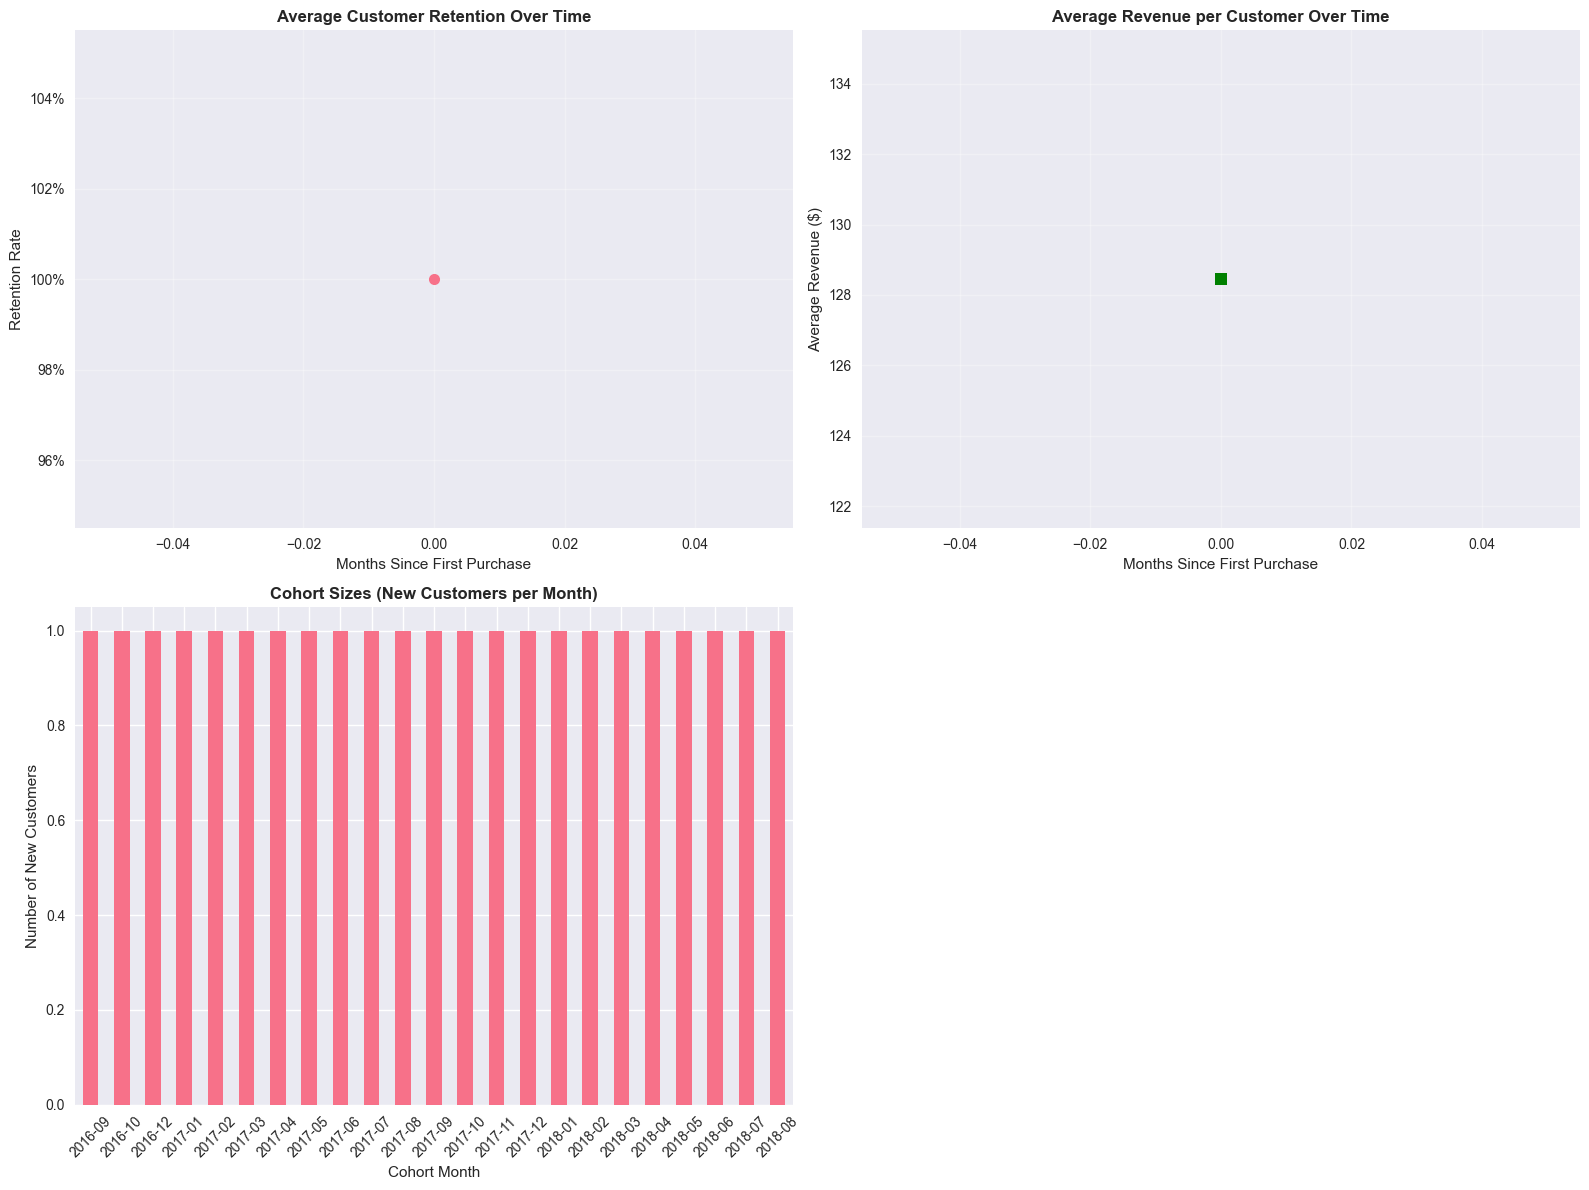


📂 Cohort metrics exported to outputs/cohort_metrics.csv


In [16]:
import os

if orders_df is not None:
    # Analyze trends
    avg_retention_by_period, avg_revenue_by_period, cohort_metrics, cohort_sizes = analyze_cohort_trends(
        retention_rates, avg_revenue_table
    )
    
    # Visualize trends
    visualize_cohort_trends(avg_retention_by_period, avg_revenue_by_period, cohort_sizes)
    
    # Ensure outputs directory exists
    os.makedirs("outputs", exist_ok=True)
    
    # Export metrics
    cohort_metrics.to_csv("outputs/cohort_metrics.csv", index=False)
    print("\n📂 Cohort metrics exported to outputs/cohort_metrics.csv")
else:
    print("⚠️ Skipping cohort analysis because data was not loaded.")
